In [1]:
# !pip install pandas
# !pip install watermark
# !pip install seaborn
# !pip install biopython|
# !pip install sklearn
import os
import re 
# from Bio import SeqIO
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np 
import watermark
import random 
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
left=4
right=6

In [3]:
# 全局变量设定
signal_num = left+right
bases="ACGT"
lower_bases="acgt"
pattern = re.compile("[^acgt]")

In [4]:
output_name = "output/DWAMoutput"
train_features_df = pd.read_csv(f'{output_name}/Train_features.csv')
test_file_df = pd.read_csv(f"{output_name}/Test_predict.csv")
test_features_df = pd.read_csv(f"{output_name}/Test_features.csv")

In [5]:
test_features_df

,-4,-3,-2,-1,0,1,2,3,4,5
0,1,2,2,2,2,3,2,0,2,1
1,3,2,3,2,2,3,0,0,2,0
2,2,3,0,2,2,3,2,0,2,3
3,3,2,1,2,2,3,0,2,2,3
4,0,1,0,2,2,3,0,0,3,3
...,...,...,...,...,...,...,...,...,...,...
151257,3,3,0,0,2,3,3,0,0,0
151258,3,0,3,0,2,3,2,2,1,1
151259,3,3,2,0,2,3,3,3,1,3
151260,3,3,1,3,2,3,3,0,3,2


In [6]:
test_fl_df = test_features_df.copy()

In [7]:
test_fl_df["Label"] = test_file_df["label"]

In [8]:
test_fl_df

,-4,-3,-2,-1,0,1,2,3,4,5,Label
0,1,2,2,2,2,3,2,0,2,1,1
1,3,2,3,2,2,3,0,0,2,0,1
2,2,3,0,2,2,3,2,0,2,3,1
3,3,2,1,2,2,3,0,2,2,3,1
4,0,1,0,2,2,3,0,0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...
151257,3,3,0,0,2,3,3,0,0,0,0
151258,3,0,3,0,2,3,2,2,1,1,0
151259,3,3,2,0,2,3,3,3,1,3,0
151260,3,3,1,3,2,3,3,0,3,2,0


In [9]:
train_features_df

,-4,-3,-2,-1,0,1,2,3,4,5,Label
0,1,0,2,3,2,3,0,0,2,3,1
1,0,3,3,1,2,3,0,0,2,3,1
2,3,0,2,2,2,3,0,0,2,0,1
3,3,1,0,2,2,3,2,2,2,2,1
4,0,2,0,2,2,3,2,0,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...
285951,0,3,2,1,2,3,2,2,2,2,0
285952,1,1,1,0,2,3,0,0,1,1,0
285953,1,1,3,0,2,3,0,0,1,1,0
285954,1,1,2,2,2,3,1,3,2,1,0


## 一次WAM

In [10]:
def cal_priorProbability(donor_signal) :
    """
    为了优化计算先验概率的性能，导致现在不能输入非atcg的了……
    """
    count= np.zeros((signal_num,4),dtype=np.int32)
    cols = tqdm(range(signal_num), desc='Calculating Prior Probability:')
    for col in cols:
        count[col]=np.bincount(donor_signal[:,col],minlength=4)[0:4]
#         count[col]=np.unique(donor_signal[:,col],return_counts=True)[1][0:4]
#     print(count)
    priors = count/len(donor_signal)
    cols.close()
    return priors

def prior_to_csv(priors,signal,mode):
    pri_col_name = [f'p({base})' for base in bases ]
    if signal=="acceptor":
        pri_row_name = list(range(-right+1,left+1))
    else:
        pri_row_name= list(range(-left,right))
    priorDf= pd.DataFrame(index=pri_row_name,columns=pri_col_name, data=priors)
#     print(priorDf)  
    if signal=="nonDonor":
        priorDf.to_csv(f'{output_name}/prior_probability_(P{mode}).csv')
    else:
        priorDf.to_csv(f'{output_name}/{signal}_prior_probability_(P{mode}).csv')
    return priorDf
import itertools
def joint_count(donor,count):
    for j in range(8):
        code1,code2 = donor[j:j+2]
        pos = 4*code1+code2
        count[j][pos] +=1
    return count
     

def cal_conditionalProbability(donor_signal,priors):
    N,M=signal_num-1,16
    count= np.zeros((N,M),dtype=np.int32)
    conditional = np.zeros((N,M),dtype=np.float32)
    donor_signal = tqdm(donor_signal, desc='Calculating Conditional Probability:')
    for donor in donor_signal:
        for j in range(N):
            if 4 not in donor[j:j+1]:
                count[j][4*donor[j]+donor[j+1]] +=1
            else:
                pass 
    #  joint
    joint= count/(len(donor_signal))
    
    # conditional P(i+1,A|i,C) = P(A,C)/P(C) 
    for k in itertools.product(range(N),range(4),range(4)):
        i = k[0]
        j = k[1]
        m = k[2]
        if priors[i][j]:
            conditional[i][4*j+m] = joint[i][4*j+m]/priors[i][j]
        else:
            pass
    return conditional

def conditional_to_csv(conditional,signal,mode):
    conditional_col_name = [f'p({i},{j})' for i in bases for j in bases ]
    conditional_row_name=list(range(-left+1,right))
    conditionalDf= pd.DataFrame(index=conditional_row_name,columns=conditional_col_name, data=conditional)
#     print(conditionalDf) 
    if signal=="nonDonor":
        conditionalDf.to_csv(f'{output_name}/conditionalDf_probability(P{mode}).csv')
    else:
        conditionalDf.to_csv(f'{output_name}/{signal}_conditionalDf_probability(P{mode}).csv')
    return conditionalDf

In [11]:
train_donor_signal_int = np.array(train_features_df[train_features_df["Label"]==1].iloc[:,:-1])
priorP=cal_priorProbability(train_donor_signal_int)
conditionalP = cal_conditionalProbability(train_donor_signal_int,priorP)


Calculating Conditional Probability:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [00:00<00:00, 25949.83it/s]


In [12]:
nonDonor_array = np.array(train_features_df[train_features_df["Label"]==0].iloc[:,:-1])
priorN = cal_priorProbability(nonDonor_array)
# df_prior_n = prior_to_csv(prior_n,signal="pseudoDonor",mode="-")
conditionalN  = cal_conditionalProbability(nonDonor_array,priorN)
# df_conditional_n = conditional_to_csv(conditionalN,signal="pseudoDonor",mode="-")

Calculating Conditional Probability:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 283575/283575 [00:12<00:00, 23143.87it/s]


In [13]:
def log_c(num,ex_mini=10e-15):
    if num == 0:
        return np.log(ex_mini)
    else:
        return np.log(num)

    
def cal_WAM(seq, priorA=priorP[0], priorB=priorN[0], conditionalA=conditionalP, conditionalB=conditionalN):
#     seq = process_donors(seq)
    S = np.log(priorA[seq[0]]) - np.log(priorB[seq[0]])
    for i in range(signal_num-1):
        S += log_c(conditionalA[i,seq[i]*4+seq[i+1]]) - log_c(conditionalB[i,seq[i]*4+seq[i+1]])
    return S

donor_strs = tqdm(train_donor_signal_int, desc='Calculating Donor signal score:')
scores=list(map(cal_WAM,donor_strs))

Calculating Donor signal score:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [00:00<00:00, 13263.08it/s]


In [14]:
pseudoDonor_strs = tqdm(nonDonor_array, desc='Calculating Non scores:')
pseudo_scores=list(map(cal_WAM,pseudoDonor_strs))

Calculating Non scores:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283575/283575 [00:29<00:00, 9679.24it/s]


In [15]:
s1 = pd.Series(scores)
print(s1.describe())
s1.describe().to_csv(f"{output_name}/donor_score_describe.csv")

count    2381.000000
mean        2.847286
std         1.510292
min        -4.737974
25%         1.849048
50%         2.855076
75%         4.099142
max         5.992512
dtype: float64


In [16]:
s2 = pd.Series(pseudo_scores)
print(s2.describe())
s2.describe().to_csv(f"{output_name}/pseudoDonor_score_describe.csv")

count    283575.000000
mean         -3.017826
std           2.324743
min          -8.576608
25%          -4.807191
50%          -3.108952
75%          -1.478723
max           5.992512
dtype: float64


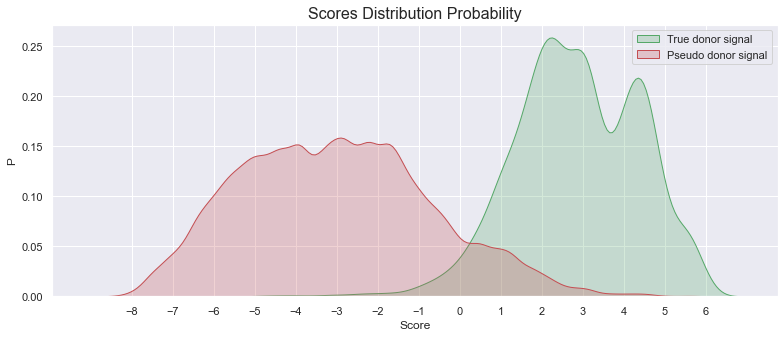

In [17]:
# 真假位点的分值分布图
sns.set(style='darkgrid')
fig,axes = plt.subplots(1,1,figsize=(13,5))
ax1 = sns.kdeplot(scores,shade=True,color="g",bw_adjust=1,cut=3,cumulative=False,label="True donor signal",ax=axes)
ax1 = sns.kdeplot(pseudo_scores,shade=True,color="r",bw_adjust=1,cut=3,cumulative=False,label="Pseudo donor signal",ax=axes)
ax1.set_ylabel('P')
ax1.set_xlabel("Score")
ax1.set_xticks(np.arange(-8,7,1))
ax1.legend()
ax1.set_title('Scores Distribution Probability',fontsize=16)
fig.savefig(f'{output_name}/Distribution_Probability.png',dpi = 200) #路径+文件名

In [18]:
test_true_array = np.array(test_fl_df[test_fl_df["Label"]==1].iloc[:,:-1])
test_true_array = tqdm(test_true_array, desc='Calculating Non scores:')
test_true_scores=list(map(cal_WAM,test_true_array))
s3 = pd.Series(test_true_scores)
print(s3.describe())

Calculating Non scores:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2079/2079 [00:00<00:00, 8487.52it/s]

count    2079.000000
mean        2.972861
std         1.526555
min        -6.527393
25%         1.976894
50%         3.011148
75%         4.218774
max         5.992512
dtype: float64


In [19]:
test_false_array = np.array(test_fl_df[test_fl_df["Label"]==0].iloc[:,:-1])
test_false_array = tqdm(test_false_array, desc='Calculating Non scores:')
test_false_scores=list(map(cal_WAM,test_false_array))
s4 = pd.Series(test_true_scores)
print(s4.describe())

Calculating Non scores:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149183/149183 [00:15<00:00, 9353.11it/s]

count    2079.000000
mean        2.972861
std         1.526555
min        -6.527393
25%         1.976894
50%         3.011148
75%         4.218774
max         5.992512
dtype: float64


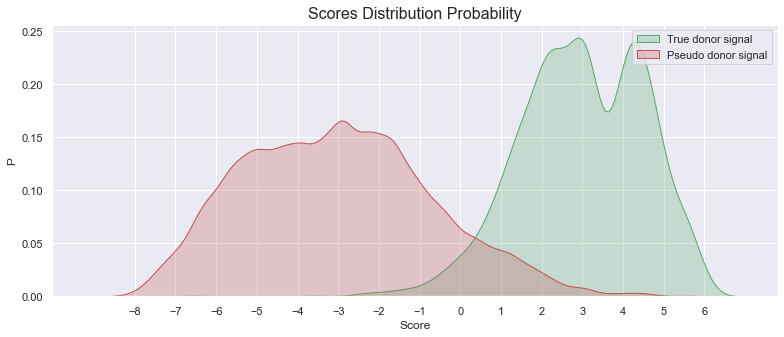

In [20]:
# 测试集真假位点的分值分布图
sns.set(style='darkgrid')
fig,axes = plt.subplots(1,1,figsize=(13,5))
ax1 = sns.kdeplot(test_true_scores,shade=True,color="g",bw_adjust=1,cut=3,cumulative=False,label="True donor signal",ax=axes)
ax1 = sns.kdeplot(test_false_scores,shade=True,color="r",bw_adjust=1,cut=3,cumulative=False,label="Pseudo donor signal",ax=axes)
ax1.set_ylabel('P')
ax1.set_xlabel("Score")
ax1.set_xticks(np.arange(-8,7,1))
ax1.legend()
ax1.set_title('Scores Distribution Probability',fontsize=16)
fig.savefig(f'{output_name}/Distribution_Probability.png',dpi = 200) #路径+文件名

## 二次WAM

### 筛选训练集

In [21]:
train_all_array = np.array(train_features_df.iloc[:,:-1])
train_all_array = tqdm(train_all_array, desc='Calculating Non scores:')
train_all_scores=list(map(cal_WAM,train_all_array ))

Calculating Non scores:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285956/285956 [00:27<00:00, 10513.67it/s]


In [22]:
train_all_scores

[2.0435140668737333,
 2.46971481295585,
 2.1493902069243,
 1.9606892329367205,
 5.111932210645669,
 1.3811821877347867,
 2.8809510409223478,
 0.5490342914449613,
 1.6903796554026544,
 4.343795583835464,
 3.18670413498258,
 3.7246576487409513,
 3.803945636790747,
 2.341134421548837,
 1.5544271990871366,
 1.488947318187575,
 3.391593031606668,
 2.6926441132413785,
 3.0111478429945513,
 2.936462378543371,
 2.6619877755033414,
 5.602644300502295,
 2.0686267477186724,
 4.073755496679489,
 3.557925031772475,
 2.464680425844186,
 5.580618375478927,
 1.7860702038226068,
 2.277644084087233,
 1.3024059296069086,
 0.5381357595539027,
 1.5594699904537135,
 1.8490476966319025,
 2.8076708674845636,
 2.3398414016184748,
 4.677125745950882,
 2.2055970192370355,
 1.0090148311766192,
 3.8269534632778104,
 3.391593031606668,
 5.863205903707687,
 0.18926881372056448,
 2.738277189455026,
 3.730466537199014,
 2.013636404215042,
 1.9675318360743468,
 -1.9395245373857577,
 1.7541174054560602,
 4.6401629805979

In [23]:
# train_second = train_features_df.copy()

In [40]:
tqdm.pandas(desc='pandas bar')
train_features_df['WAMScore'] = train_all_scores
# 确定二次阈值
Threshold  =-4
# Threshold  =                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
train_features_df['WAMfilter'] = train_features_df.progress_apply(lambda x: 1 if x.WAMScore > Threshold else 0, axis=1)
# 当阈值为-3的时候，训练集少了一半
print(train_features_df.WAMfilter.sum())

pandas bar: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285956/285956 [00:03<00:00, 73324.75it/s]

181797


In [41]:
train_second_df = train_features_df[train_features_df["WAMfilter"]==1]
train_second_df

,-4,-3,-2,-1,0,1,2,3,4,5,Label,WAMScore,WAMfilter
0,1,0,2,3,2,3,0,0,2,3,1,2.043514,1
1,0,3,3,1,2,3,0,0,2,3,1,2.469715,1
2,3,0,2,2,2,3,0,0,2,0,1,2.149390,1
3,3,1,0,2,2,3,2,2,2,2,1,1.960689,1
4,0,2,0,2,2,3,2,0,2,3,1,5.111932,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285951,0,3,2,1,2,3,2,2,2,2,0,-0.536870,1
285952,1,1,1,0,2,3,0,0,1,1,0,-1.240218,1
285953,1,1,3,0,2,3,0,0,1,1,0,-2.148236,1
285954,1,1,2,2,2,3,1,3,2,1,0,-1.043116,1


In [42]:
train_second_features = train_second_df.iloc[:,:-2]

In [43]:
train_second_donor = np.array(train_second_features[train_second_features["Label"]==1].iloc[:,:-1])
priorP_2=cal_priorProbability(train_second_donor)
conditionalP_2 = cal_conditionalProbability(train_second_donor,priorP_2)
train_second_nonDonor = np.array(train_second_features[train_second_features["Label"]==0].iloc[:,:-1])
priorN_2 = cal_priorProbability(train_second_nonDonor)
conditionalN_2  = cal_conditionalProbability(train_second_nonDonor,priorN_2)

Calculating Conditional Probability:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 179418/179418 [00:08<00:00, 22185.72it/s]


In [44]:
def cal_WAM_2(seq, priorA=priorP_2[0], priorB=priorN_2[0], conditionalA=conditionalP_2 , conditionalB=conditionalN_2):
#     seq = process_donors(seq)
    S = np.log(priorA[seq[0]]) - np.log(priorB[seq[0]])
    for i in range(signal_num-1):
        S += log_c(conditionalA[i,seq[i]*4+seq[i+1]]) - log_c(conditionalB[i,seq[i]*4+seq[i+1]])
    return S

In [45]:
train_second_donor

array([[1, 0, 2, ..., 0, 2, 3],
       [0, 3, 3, ..., 0, 2, 3],
       [3, 0, 2, ..., 0, 2, 0],
       ...,
       [2, 0, 1, ..., 0, 2, 3],
       [0, 2, 0, ..., 0, 2, 3],
       [0, 1, 0, ..., 0, 1, 3]], dtype=int64)

In [46]:
donor2_strs = tqdm(train_second_donor, desc='Calculating Donor signal score:')
scores_2=list(map(cal_WAM_2,donor2_strs))

Calculating Donor signal score:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2379/2379 [00:00<00:00, 10134.87it/s]


In [47]:
nonDonor2_strs = tqdm(train_second_nonDonor, desc='Calculating Donor signal score:')
pseudo2_scores=list(map(cal_WAM_2,nonDonor2_strs))

Calculating Donor signal score:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 179418/179418 [00:15<00:00, 11854.13it/s]


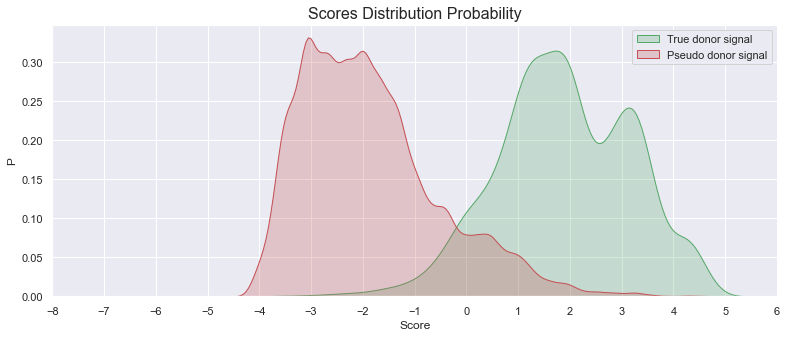

In [48]:
# 真假位点的分值分布图
sns.set(style='darkgrid')
fig,axes = plt.subplots(1,1,figsize=(13,5))
ax1 = sns.kdeplot(scores_2,shade=True,color="g",bw_adjust=1,cut=3,cumulative=False,label="True donor signal",ax=axes)
ax1 = sns.kdeplot(pseudo2_scores,shade=True,color="r",bw_adjust=1,cut=3,cumulative=False,label="Pseudo donor signal",ax=axes)
ax1.set_ylabel('P')
ax1.set_xlabel("Score")
ax1.set_xticks(np.arange(-8,7,1))
ax1.legend()
ax1.set_title('Scores Distribution Probability',fontsize=16)
fig.savefig(f'{output_name}/2-WAM-Distribution_Probability.png',dpi = 200)

In [49]:
# train_filtered[train_filtered["Label"]==0].sample(2080).reset_index(drop=True)
# train_df = pd.concat([train_filtered[train_filtered["Label"]==1],train_filtered[train_filtered["Label"]==0].sample(2080).reset_index(dr

### 测试集重打分

In [50]:
test_all_array = np.array(test_features_df)
test_all_array  = tqdm(test_all_array , desc='Calculating Non scores:')
test_all_scores=list(map(cal_WAM,test_all_array  ))

Calculating Non scores:: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151262/151262 [00:13<00:00, 11169.27it/s]


In [51]:
test_fl_df['WAMScore'] = test_all_scores
# Threshold  =-3
# Threshold  =0.43
test_fl_df['WAMfilter'] = test_fl_df.progress_apply(lambda x: 1 if x.WAMScore > Threshold else 0, axis=1)
# 当阈值为-3的时候，训练集少了一半
print(test_fl_df.WAMfilter.sum())

pandas bar: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151262/151262 [00:02<00:00, 56784.95it/s]

97024


In [52]:
# test_fl_df['predict'] =0
# test_fl_df

In [53]:
test_second_df = test_fl_df[test_fl_df["WAMfilter"]==1].reset_index(drop=True)
test_second_df

,-4,-3,-2,-1,0,1,2,3,4,5,Label,WAMScore,WAMfilter
0,1,2,2,2,2,3,2,0,2,1,1,2.537710,1
1,3,2,3,2,2,3,0,0,2,0,1,2.073892,1
2,2,3,0,2,2,3,2,0,2,3,1,2.898115,1
3,3,2,1,2,2,3,0,2,2,3,1,3.235371,1
4,0,1,0,2,2,3,0,0,3,3,1,1.962227,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97019,0,1,3,3,2,3,3,2,2,1,0,-2.738451,1
97020,1,2,0,3,2,3,3,2,2,0,0,-2.158218,1
97021,3,3,1,3,2,3,0,0,3,3,0,-2.335033,1
97022,0,0,0,0,2,3,3,3,2,0,0,-2.893967,1


In [56]:
test_second_array =np.array(test_second_df.iloc[:,:-3])

In [57]:
test_second_strs = tqdm(test_second_array)
test_second_scores=list(map(cal_WAM_2,test_second_strs))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97024/97024 [00:07<00:00, 12474.39it/s]


In [58]:
test_fl_df.loc[test_fl_df["WAMfilter"]==0,"D-Score"]= -9

In [59]:
test_fl_df.loc[test_fl_df["WAMfilter"]==1,"D-Score"]= test_second_scores
test_fl_df

,-4,-3,-2,-1,0,1,2,3,4,5,Label,WAMScore,WAMfilter,D-Score
0,1,2,2,2,2,3,2,0,2,1,1,2.537710,1,1.502043
1,3,2,3,2,2,3,0,0,2,0,1,2.073892,1,1.199766
2,2,3,0,2,2,3,2,0,2,3,1,2.898115,1,2.138791
3,3,2,1,2,2,3,0,2,2,3,1,3.235371,1,2.046516
4,0,1,0,2,2,3,0,0,3,3,1,1.962227,1,1.183331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151257,3,3,0,0,2,3,3,0,0,0,0,-6.237602,0,-9.000000
151258,3,0,3,0,2,3,2,2,1,1,0,-5.118892,0,-9.000000
151259,3,3,2,0,2,3,3,3,1,3,0,-5.993607,0,-9.000000
151260,3,3,1,3,2,3,3,0,3,2,0,-5.351315,0,-9.000000


In [60]:
test_fl_df.to_csv("BNoutput/D-WAM_predict.csv",index=None)

In [61]:

WAM_predict_scores = pd.read_csv("output/WAM(-4+6)/WAM_predict_scores.csv")["scores"]
WAM_test_labels   = pd.read_csv("output/WAM(-4+6)/WAM_predict_scores.csv")["labels"]

In [62]:
test_labels = [WAM_test_labels,test_fl_df["Label"]]
test_scores = [WAM_predict_scores,test_fl_df["D-Score"]]

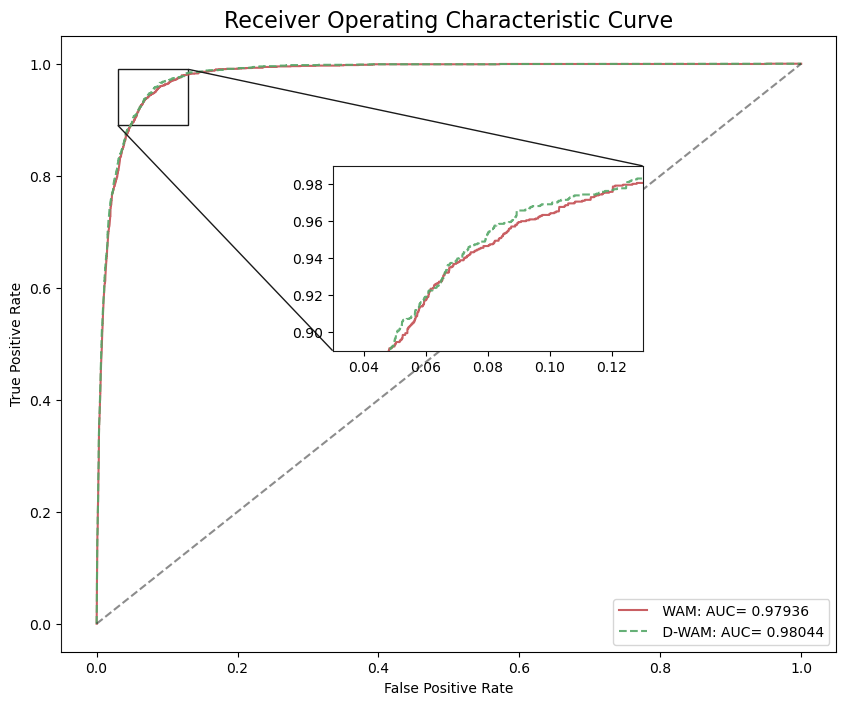

In [63]:
# ROC plot
# problem ： 如何画不同核的图在一个图里
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import matplotlib.pyplot as plt
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

def plot_roc(labels, predict_probs, titles):
    color = ['r', 'g', 'b', 'y','c','m']                                                                 
    linestyles = ['-','--',':','-.']
#     markers = ['v','o','p','+','1','D',',','.']
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    for idx, predict_prob in enumerate(predict_probs):
        fpr, tpr,thresholds=roc_curve(labels[idx], predict_prob)
        roc_auc=auc(fpr, tpr)
        if idx==1:
            optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
        c = color[idx%len(color)]                                                                     
        l =linestyles[idx%len(linestyles)]
#         m = markers [idx%len( markers )]
        ax.plot(fpr, tpr,'b',label=f' {titles[idx]}: AUC= {roc_auc:.5f}', color=c, linestyle=l, alpha=0.9,markevery=20)  
        ax.legend(loc='lower right')
    # 
    axins = inset_axes(ax, width="40%", height="30%",loc='upper center',
                   bbox_to_anchor=(0.05, -0.2, 1, 1),
                   bbox_transform=ax.transAxes)
    for idx, predict_prob in enumerate(predict_probs):
        false_positive_rate,true_positive_rate,thresholds=roc_curve(labels[idx], predict_prob)
        roc_auc=auc(false_positive_rate, true_positive_rate)
        c = color[idx%len(color)]                                                                     
        l =linestyles[idx%len(linestyles)]
        
#         m = markers [idx%len( markers )]
        axins.plot(false_positive_rate, true_positive_rate,'b', color=c, linestyle=l, alpha=0.9,markevery=20)  

    axins.set_xlim(0.03, 0.13)
    axins.set_ylim(0.89, 0.99)
    #
    mark_inset(ax, axins, loc1=3,loc2=1, fc="none", ec='k', lw=1)
    ax.plot([0,1],[0,1],'k--',alpha=0.5)
    ax.set_title("Receiver Operating Characteristic Curve",fontsize=16)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    ax.spines['left'].set_color('k')
    [axins.spines[loc_axis].set_color('k') for loc_axis in ['top','right','bottom','left']]
    plt.savefig(f'{output_name}/D-WAMROC_plot.png',dpi=120)
    plt.show()
    return optimal_th

plt.style.use('default')

optimal_th=plot_roc(test_labels,test_scores,titles=["WAM","D-WAM"])



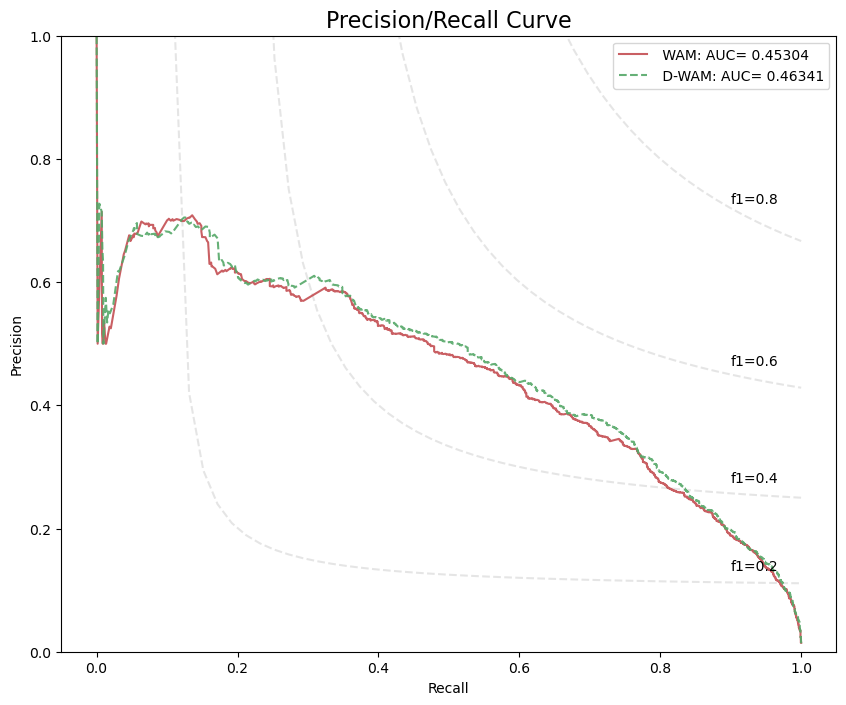

In [64]:
from sklearn.metrics import precision_recall_curve
def plot_pr(labels, predict_probs, titles):
    color = ['r', 'g', 'b', 'y','c','m']                                                                 
    linestyles = ['-','--',':','-.']
    plt.figure(figsize=(10, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray',linestyle='--' ,alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    for idx, predict_prob in enumerate(predict_probs):
        precision, recall, thresholds = precision_recall_curve(labels[idx], predict_prob)
        pr_auc=auc(recall, precision)
        c = color[idx%len(color)]                                                                     

        l =linestyles[idx%len(linestyles)]
        plt.plot(recall,precision,'b',label=f' {titles[idx]}: AUC= {pr_auc:.5f}',color=c, linestyle=l, alpha=0.9,markevery=20)  
        plt.legend(loc='lower right')
    plt.ylim(0,1)
    # plt.plot([0,1],[1,0],color='gray',linestyle='--',alpha=0.5)
    plt.title('Precision/Recall Curve',fontsize=16)# give plot a title
    plt.xlabel('Recall')# make axis labels
    plt.ylabel('Precision')
    plt.legend(loc="upper right")
    f = plt.gcf()  
    f.savefig(f'{output_name}/D-WAM_PR_plot.png',dpi=120)
    plt.show()
plt.style.use('default')
thresholds=plot_pr(test_labels,test_scores,titles=["WAM","D-WAM"])
